In [1]:
import pandas as pd
import numpy as np
import polars as pl
import polars.selectors as cs
import sys, os, re
import pickle as pkl
import dproc, sgml, sgutil
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

print(sys.version)

for i in [pd, pl, np, lgb, xgb, cb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.3 (main, May  1 2024, 17:33:23) [GCC 11.4.0]
pandas 2.2.2
polars 1.12.0
numpy 1.26.4
lightgbm 4.3.0
xgboost 2.1.2
catboost 1.2.5


## Data Acquisition

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'data.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('org_parquet', data_path, 'org.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if not os.path.isfile(files['train']):
    !kaggle competitions download -c playground-series-s4e6
    !unzip playground-series-s4e6.zip -d data
    !rm playground-series-s4e6.zip
    !wget https://archive.ics.uci.edu/static/public/697/predict+students+dropout+and+academic+success.zip
    !unzip predict+students+dropout+and+academic+success.zip -d data
    !rm predict+students+dropout+and+academic+success.zip

if not os.path.exists(files['var_pkl']):
    # UCI Repository에서 수집한 변수 정보를 variable.tsv에 저장해두었습니다.
    # 이를 불러옵니다.
    df_var = pd.read_csv('variables.tsv', sep='\t')\
        .drop(columns=['Units', 'Missing Values'])\
        .rename(columns={'Variable Name': 'name'})\
        .set_index('name')
    
    # 변수의 타입을 정하기 위한 정보를 수집해와서 변수의 타입을 정합니다.
    df_type = dproc.merge_type_df([
        pl.scan_csv(files['train']).pipe(dproc.get_type_df).pipe(lambda x: x.set_index(x.index.map(lambda x: x.strip()))),
        pl.scan_csv(files['test']).pipe(dproc.get_type_df).pipe(lambda x: x.set_index(x.index.map(lambda x: x.strip()))),
        pl.scan_csv(files['org'], separator=';').pipe(dproc.get_type_df).pipe(lambda x: x.set_index(x.index.map(lambda x: x.strip())))
    ])
    dt = dproc.get_type_pl(df_type)
    df_var = pd.concat([
        df_var,
        df_type.drop(columns='dtype'),
        pd.Series(dt, name='pl_type'),
        pd.Series(dt, name='dtype').astype('str')
    ], axis=1)
    pl.scan_csv(files['train'], schema_overrides = dt).sink_parquet(files['train_parquet'])
    pl.scan_csv(files['test'], schema_overrides = dt).sink_parquet(files['test_parquet'])
    pl.scan_csv(files['org'], schema_overrides = dt).sink_parquet(files['org_parquet'])
    df_var.to_pickle(files['var_pkl'])
else:
    df_var = pd.read_pickle(files['var_pkl'])
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_org = pl.read_parquet(files['test_parquet'])
df_var

,Role,Type,Demographic,Description,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype
Marital status,Feature,Integer,Marital status,1 – single 2 – married 3 – widower 4 – divorce...,1.00,6.000000,0.0,131954.0,6.000000,True,True,True,True,Int8,Int8
Application mode,Feature,Integer,NaN,1 - 1st phase - general contingent 2 - Ordinan...,1.00,57.000000,0.0,131954.0,20.000000,True,True,True,True,Int8,Int8
Application order,Feature,Integer,NaN,Application order (between 0 - first choice; a...,0.00,9.000000,0.0,131954.0,8.000000,True,True,True,True,Int8,Int8
Course,Feature,Integer,NaN,33 - Biofuel Production Technologies 171 - Ani...,33.00,9991.000000,0.0,131954.0,19.000000,True,True,True,False,Int16,Int16
Daytime/evening attendance,Feature,Integer,NaN,1 – daytime 0 - evening,0.00,1.000000,0.0,131954.0,2.000000,True,True,True,True,Int8,Int8
Previous qualification,Feature,Integer,Education Level,1 - Secondary education 2 - Higher education -...,1.00,43.000000,0.0,131954.0,19.333333,True,True,True,True,Int8,Int8
Previous qualification (grade),Feature,Continuous,NaN,Grade of previous qualification (between 0 and...,95.00,190.000000,0.0,131954.0,106.333333,True,True,True,False,Float32,Float32
Nacionality,Feature,Integer,Nationality,1 - Portuguese; 2 - German; 6 - Spanish; 11 - ...,1.00,109.000000,0.0,131954.0,19.000000,True,True,True,True,Int8,Int8
Mother's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,1.00,44.000000,0.0,131954.0,32.000000,True,True,True,True,Int8,Int8
Father's qualification,Feature,Integer,Education Level,1 - Secondary Education - 12th Year of Schooli...,1.00,44.000000,0.0,131954.0,36.333333,True,True,True,True,Int8,Int8


# Global Variables & Common Routine

In [3]:
target = 'Target'
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [4]:
# End of Polars Processing
df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')
df_org = df_org.to_pandas().set_index('id')

# Train / Test Difference

In [5]:
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
X_cat = df_var.loc[df_var['Description'].fillna('').str.contains('[0-9]{1,2} [-–] ')].index.to_list()
X_num = df_var.loc[(~df_var.index.isin(X_cat + [target, 'id']))].index.to_list()
X_all = X_cat + X_num
ct = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, encoded_missing_value=0), X_cat),
    ('pt', 'passthrough', X_num)
]).set_output(transform='pandas')
result = sc.cache_result('classify_train_test',
    lambda : pd.concat([
        df_train[X_all].assign(is_train=True),
        df_test[X_all].assign(is_train=False)
    ], axis=0).pipe(
        lambda x: cross_validate(
            Pipeline([
                ('ct', ct), 
                ('lgb', lgb.LGBMClassifier(verbose=-1, n_estimators=1000))
            ]), x[X_all], x['is_train'], scoring='roc_auc', cv=ss, return_train_score=True, return_estimator=True, 
            params={'lgb__categorical_feature': ['ord__' + i for i in X_cat]}
        )
    )
)
result['train_score'], result['test_score']

(array([0.901298]), array([0.50412542]))

## Categorical Variables

In [6]:
pd.concat([
    df_train[X_cat].agg(set).rename('train'),
    df_test[X_cat].agg(set).rename('test')
], axis=1).apply(
    lambda x: x['test'] - x['train']
    , axis=1
)

Marital status                                      {}
Application mode                              {19, 14}
Application order                                   {}
Course                        {9257, 4147, 7500, 2105}
Daytime/evening attendance                          {}
Previous qualification                            {16}
Nacionality                                       {14}
Mother's qualification                        {25, 13}
Father's qualification                        {16, 28}
Mother's occupation           {98, 133, 174, 181, 154}
Father's occupation                         {120, 113}
Displaced                                           {}
Educational special needs                           {}
Debtor                                              {}
Tuition fees up to date                             {}
Gender                                              {}
Scholarship holder                                  {}
International                                       {}
dtype: obj

# Categorical Variables

범주형 변수 설명에는 정수로 표신된 값의 원래 범주값 이 있습니다. 가져옵니다.

저빈도 범주중에서 고빈도 범주와 비슷한 의미를 지닌 단어가 존재합니다. 이를 고빈도 범주로 치환하여 범주형 변수로 만듭니다.

In [7]:
X_cat = df_var.loc[df_var['Description'].fillna('').str.contains('[0-9]{1,2} [-–] ')].index.to_list()
s_cat_dict = df_var.loc[X_cat, 'Description'].str.split("([0-9]+) [-|–] ").apply(lambda x: {int(a): b.strip() for a, b in zip(x[1::2], x[2::2])})
s_cat_dict

Marital status                {1: 'single', 2: 'married', 3: 'widower', 4: '...
Application mode              {1: '1st phase - general contingent', 2: 'Ordi...
Application order                       {0: 'first choice; and 9 last choice)'}
Course                        {33: 'Biofuel Production Technologies', 171: '...
Daytime/evening attendance                         {1: 'daytime', 0: 'evening'}
Previous qualification        {1: 'Secondary education', 2: 'Higher educatio...
Nacionality                   {1: 'Portuguese;', 2: 'German;', 6: 'Spanish;'...
Mother's qualification        {1: 'Secondary Education - 12th Year of School...
Father's qualification        {1: 'Secondary Education - 12th Year of School...
Mother's occupation           {0: 'Student', 1: 'Representatives of the Legi...
Father's occupation           {0: 'Student', 1: 'Representatives of the Legi...
Displaced                                                   {1: 'yes', 0: 'no'}
Educational special needs               

## 범주값 정리

In [8]:
s_tmp = df_train['Marital status'].astype('category').map(s_cat_dict.loc['Marital status'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Marital status,,,,
single,0.490490,0.309536,0.199974,70189
married,0.300793,0.560423,0.138784,5296
widower,0.437500,0.437500,0.125000,16
divorced,0.242494,0.587760,0.169746,866
facto union,0.344828,0.543103,0.112069,116
legally separated,0.142857,0.657143,0.200000,35


In [9]:
def get_marital_proc():
    s_dict = s_cat_dict.loc['Marital status']
    repl_dict = {'widower': 'single', 'legally separated': 'divorced', 'facto union': 'married'}
    
    c = pd.CategoricalDtype(pd.Series(s_dict).replace(repl_dict).unique().tolist())
    return lambda x: dproc.replace_cat(
        x['Marital status'].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
    ).rename('Marital status_R').astype(c)
marital_proc = get_marital_proc()

In [10]:
s_tmp = df_train['Application mode'].astype('category').map(s_cat_dict.loc['Application mode'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Application mode,,,,
1st phase - general contingent,0.610611,0.187782,0.201607,35227
1st phase - special contingent (Azores Island),0.471264,0.206897,0.321839,87
1st phase - special contingent (Madeira Island),0.660377,0.154717,0.184906,265
2nd phase - general contingent,0.494704,0.292380,0.212915,16523
3rd phase - general contingent,0.443471,0.406847,0.149682,1256
Change of course,0.332085,0.407338,0.260577,2671
Change of institution/course,0.411765,0.328054,0.260181,442
Holders of other higher courses,0.214286,0.721629,0.064085,1498
International student (bachelor),0.459016,0.224044,0.316940,183


In [11]:
def get_app_mode_proc():
    s_dict = s_cat_dict.loc['Application mode']
    repl_dict = {i : 'Ordinance' for i in s_dict.values() if i.startswith('Ordinance')}
    
    c = pd.CategoricalDtype(
        pd.Series(s_dict).pipe(
            lambda x: x.loc[x.index.isin(df_train['Application mode'].unique())]
        ).replace(repl_dict).unique()
    )
    return lambda x: dproc.replace_cat(
        x['Application mode'].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
    ).rename('Application mode_R').astype(c).fillna('Ordinance')
app_mode_proc = get_app_mode_proc()
app_mode_proc(df_train).value_counts()

Application mode_R
1st phase - general contingent                     35227
2nd phase - general contingent                     16523
Over 23 years old                                  14519
Technological specialization diploma holders        3012
Change of course                                    2671
Holders of other higher courses                     1498
3rd phase - general contingent                      1256
Transfer                                             551
Change of institution/course                         442
1st phase - special contingent (Madeira Island)      265
Short cycle diploma holders                          225
International student (bachelor)                     183
1st phase - special contingent (Azores Island)        87
Ordinance                                             59
Name: count, dtype: int64

In [12]:
s_tmp = df_train['Application order'].astype('category')
s_vcnt = s_tmp.value_counts().rename('count')
display(
    pd.crosstab(
        index=s_tmp,
        columns=df_train[target], normalize='index'
    ).rename(columns=lambda x: x).join(s_vcnt)
)

def get_app_order_proc():
    return lambda x: x['Application order'].clip(1, 6).rename('Application order_C')
app_order_proc = get_app_order_proc()
app_order_proc(df_train).value_counts()

,Graduate,Dropout,Enrolled,count
Application order,,,,
0,0.333333,0.666667,0.000000,3
1,0.429360,0.364631,0.206009,54381
2,0.538254,0.267268,0.194479,8875
3,0.615772,0.212901,0.171327,5364
4,0.650706,0.226321,0.122972,3822
5,0.459294,0.359529,0.181176,2125
6,0.713405,0.165383,0.121212,1947
9,0.000000,0.000000,1.000000,1


Application order_C
1    54384
2     8875
3     5364
4     3822
5     2125
6     1948
Name: count, dtype: int64

In [13]:
s_tmp = df_train['Course'].astype('category').map(s_cat_dict.loc['Course'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Course,,,,
Advertising and Marketing Management,0.431723,0.339916,0.228361,4760
Agronomy,0.279400,0.525583,0.195017,3733
Animation and Multimedia Design,0.214760,0.712487,0.072753,2859
Basic Education,0.281426,0.365541,0.353033,3198
Biofuel Production Technologies,0.111111,0.750000,0.138889,72
Communication Design,0.640963,0.210607,0.148430,3281
Equinculture,0.226650,0.546077,0.227273,1606
Informatics Engineering,0.049601,0.598202,0.352197,3004
Journalism and Communication,0.680058,0.222547,0.097395,8214


In [14]:
def get_course_proc():
    s_dict = s_cat_dict.loc['Course']
    c = pd.CategoricalDtype(
        ['Unknown'] + pd.Series(s_dict).unique().tolist()
    )
    print(c.categories)
    return lambda x: dproc.replace_cat(
        x['Course'].astype('category'), lambda x: 'Unknown' if x not in s_dict else s_dict[x]
    ).rename('Course_R').astype(c)
course_proc = get_course_proc()
course_proc(df_train).value_counts()

Index(['Unknown', 'Biofuel Production Technologies',
       'Animation and Multimedia Design',
       'Social Service (evening attendance)', 'Agronomy',
       'Communication Design', 'Veterinary Nursing', 'Informatics Engineering',
       'Equinculture', 'Management', 'Social Service', 'Tourism', 'Nursing',
       'Oral Hygiene', 'Advertising and Marketing Management',
       'Journalism and Communication', 'Basic Education',
       'Management (evening attendance)'],
      dtype='object')


Course_R
Nursing                                 12074
Journalism and Communication             8214
Social Service                           7935
Management                               7741
Tourism                                  5425
Veterinary Nursing                       5373
Advertising and Marketing Management     4760
Management (evening attendance)          4057
Agronomy                                 3733
Communication Design                     3281
Basic Education                          3198
Informatics Engineering                  3004
Animation and Multimedia Design          2859
Social Service (evening attendance)      2438
Equinculture                             1606
Oral Hygiene                              746
Biofuel Production Technologies            72
Unknown                                     2
Name: count, dtype: int64

In [15]:
s_tmp = df_train['Previous qualification'].astype('category').map(s_cat_dict.loc['Previous qualification'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Previous qualification,,,,
10th year of schooling,0.000000,1.000000,0.000000,3
10th year of schooling - not completed,0.090909,0.818182,0.090909,11
11th year of schooling - not completed,0.093023,0.883721,0.023256,43
12th year of schooling - not completed,0.019481,0.961039,0.019481,308
Basic education 2nd cycle (6th/7th/8th year) or equiv.,0.315789,0.552632,0.131579,38
Basic education 3rd cycle (9th/10th/11th year) or equiv.,0.188666,0.732270,0.079063,2947
Frequency of higher education,0.428571,0.459184,0.112245,98
Higher education - bachelor's degree,0.306122,0.612245,0.081633,98
Higher education - degree,0.213419,0.743754,0.042827,1401


In [16]:
def get_prev_qual_proc():
    s_dict = s_cat_dict.loc['Previous qualification']
    repl_dict = {
        '10th year of schooling': 'Basic education 3rd cycle (9th/10th/11th year) or equiv.', 
        '10th year of schooling - not completed': 'Basic education 3rd cycle (9th/10th/11th year) or equiv.', 
        '11th year of schooling - not completed': 'Other - 11th year of schooling',
        'Higher education - doctorate': 'Frequency of higher education',
        "Higher education - master (2nd cycle)": "Higher education - master's"
    }
    
    c = pd.CategoricalDtype(['Unknown'] + pd.Series(s_dict).replace(repl_dict).unique().tolist())
    return lambda x: dproc.replace_cat(
        x['Previous qualification'].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
    ).rename('Previous qualification_R').astype(c).fillna('Unknown')
prev_qual_proc = get_prev_qual_proc()
prev_qual_proc(df_train).value_counts()

Previous qualification_R
Secondary education                                         67183
Basic education 3rd cycle (9th/10th/11th year) or equiv.     2961
Technological specialization course                          2928
Higher education - degree                                    1401
Other - 11th year of schooling                                942
12th year of schooling - not completed                        308
Higher education - degree (1st cycle)                         259
Professional higher technical course                          229
Frequency of higher education                                 101
Higher education - bachelor's degree                           98
Higher education - master's                                    62
Basic education 2nd cycle (6th/7th/8th year) or equiv.         38
Unknown                                                         8
Name: count, dtype: int64

In [17]:
s_tmp = df_train['Nacionality'].astype('category').map(s_cat_dict.loc['Nacionality'])
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=df_train[target], normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
Nacionality,,,,
Portuguese;,0.474129,0.330536,0.195335,76013
German;,1.000000,0.000000,0.000000,13
Spanish;,0.357143,0.392857,0.250000,56
Italian;,0.933333,0.066667,0.000000,15
Lithuanian;,0.500000,0.500000,0.000000,2
Angolan;,0.000000,0.666667,0.333333,6
Cape Verdean;,0.625000,0.267857,0.107143,56
Guinean;,0.733333,0.066667,0.200000,15
Mozambican;,0.166667,0.666667,0.166667,6


In [18]:
def get_nacionality_proc():
    s_dict = s_cat_dict.loc['Nacionality']
    repl_dict = {i : 'etc' for i in  df_train['Nacionality'].value_counts().pipe(lambda x: x.loc[x < 10].index.map(s_dict))}
    for i in pd.Series(s_dict).pipe(lambda x: x.loc[~x.index.isin(df_train['Nacionality'].unique())]):
        repl_dict[i] = 'etc'
    c = pd.CategoricalDtype(pd.Series(s_dict).replace(repl_dict).unique())
    return lambda x: dproc.replace_cat(
        x['Nacionality'].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
    ).rename('Nacionality_R').astype(c).fillna('etc')
nacionality_proc = get_nacionality_proc()
nacionality_proc(df_train).value_counts()

Nacionality_R
Portuguese;      76013
Brazilian;         221
Santomean;          67
Spanish;            56
Cape Verdean;       56
etc                 50
Italian;            15
Guinean;            15
German;             13
Ukrainian;          12
Name: count, dtype: int64

In [19]:
s_tmp = pd.concat([
    df_train["Mother's qualification"].astype('category').map(s_cat_dict.loc["Mother's qualification"]),
    df_train["Father's qualification"].astype('category').map(s_cat_dict.loc["Father's qualification"])
]).reset_index(drop=True)
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=pd.concat([df_train[target], df_train[target]]).reset_index(drop=True), normalize='index'
).rename(columns=lambda x: x).join(s_vcnt)

,Graduate,Dropout,Enrolled,count
row_0,,,,
10th Year of Schooling,0.347826,0.608696,0.043478,23
11th Year of Schooling - Not Completed,0.280000,0.720000,0.000000,25
12th Year of Schooling - Not Completed,0.171875,0.734375,0.093750,64
2nd cycle of the general high school course,0.333333,0.666667,0.000000,3
2nd year complementary high school course,0.000000,1.000000,0.000000,3
7th Year (Old),0.392523,0.542056,0.065421,107
7th year of schooling,0.076923,0.923077,0.000000,13
8th year of schooling,0.458333,0.416667,0.125000,24
9th Year of Schooling - Not Completed,0.175000,0.725000,0.100000,40


In [20]:
def get_qual_proc():
    s_dict = s_cat_dict.loc["Mother's qualification"]
    repl_dict = repl_dict = {
        '10th Year of Schooling': 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.', 
        '11th Year of Schooling - Not Completed': 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.', 
        '9th Year of Schooling - Not Completed': 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.', 
        '2nd cycle of the general high school course': "Higher Education - Master's",
        '7th Year (Old)': 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.', 
        '7th year of schooling': 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.', 
        '8th year of schooling': 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.', 
        '12th Year of Schooling - Not Completed': 'Secondary Education - 12th Year of Schooling or Eq.',
        'Higher education - doctorate': 'Frequency of higher education',
        'Can read without having a 4th year of schooling': "Can't read or write",
        'Higher Education - Doctorate (3rd cycle)': 'Higher Education - Doctorate',
        'Professional higher technical course': 'Technological specialization course',
        'Technical-professional course': 'Technological specialization course',
        'Higher Education - Master (2nd cycle)': "Higher Education - Master's",
        "Higher Education - Bachelor's Degree": 'Higher Education - Degree',
        'Higher education - degree (1st cycle)': 'Higher Education - Degree',
        "Other - 11th Year of Schooling": 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
        'Frequency of Higher Education': 'Specialized higher studies course',
        'General commerce course': 'Specialized higher studies course'
    }
    c = pd.CategoricalDtype(pd.Series(s_dict).replace(repl_dict).unique())
    def proc(x):
        return pd.concat([
            dproc.replace_cat(
                x["Mother's qualification"].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
            ).rename("Mother's qualification_R").astype(c).fillna('Unknown'),
            dproc.replace_cat(
                x["Father's qualification"].astype('category'), {k: repl_dict.get(v, v) for k, v in s_dict.items()}
            ).rename("Father's qualification_R").astype(c).fillna('Unknown')
        ], axis=1)
    return proc
qual_proc = get_qual_proc()
df_qual = qual_proc(df_train)
pd.concat([df_qual["Mother's qualification_R"], df_qual["Father's qualification_R"]]).value_counts()

Basic education 1st cycle (4th/5th year) or equiv.          41954
Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.    38735
Secondary Education - 12th Year of Schooling or Eq.         35870
Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.      21456
Higher Education - Degree                                   10084
Unknown                                                      3806
Higher Education - Master's                                   570
Technological specialization course                           208
Higher Education - Doctorate                                  204
Specialized higher studies course                              76
Can't read or write                                            73
Name: count, dtype: int64

In [21]:
s_tmp = pd.concat([
    df_train["Mother's occupation"].astype('category').map(s_cat_dict.loc["Mother's occupation"]),
    df_train["Father's occupation"].astype('category').map(s_cat_dict.loc["Father's occupation"])
]).reset_index(drop=True)
s_vcnt = s_tmp.value_counts().rename('count')
pd.crosstab(
    index=s_tmp,
    columns=pd.concat([df_train[target], df_train[target]]).reset_index(drop=True), normalize='index'
).rename(columns=lambda x: x).join(s_vcnt).sort_values('count', ascending=False)

,Graduate,Dropout,Enrolled,count
row_0,,,,
Unskilled Workers,0.478942,0.326198,0.194860,54706
Administrative staff,0.487462,0.317686,0.194853,22730
"Personal Services, Security and Safety Workers and Sellers",0.496992,0.285565,0.217444,19113
"Skilled Workers in Industry, Construction and Craftsmen",0.536484,0.273471,0.190045,17117
Intermediate Level Technicians and Professions,0.519841,0.274862,0.205297,10307
Specialists in Intellectual and Scientific Activities,0.393168,0.365175,0.241657,6323
Installation and Machine Operators and Assembly Workers,0.539970,0.281285,0.178745,5354
Student,0.173627,0.793993,0.032379,4262
Armed Forces Professions,0.455758,0.344242,0.200000,4125


In [22]:
s_occupation = pd.concat([
    pd.Series(s_cat_dict.loc["Mother's occupation"]),
    pd.Series(s_cat_dict.loc["Father's occupation"])
]).reset_index().drop_duplicates().set_index('index')
df_occupation = s_occupation.reset_index().assign(
    tmp = lambda x: x['index'].astype('str').apply(
        lambda x: x[-2:] if x[:2] != '10' else x
    ).apply(
        lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
    )
).groupby('tmp').agg(list).rename(columns={'index': 'num', 0: 'name'})
df_occupation

,num,name
tmp,,
0,[0],[Student]
1,"[1, 112, 114]",[Representatives of the Legislative Power and ...
10,"[10, 101, 102, 103]","[Armed Forces Professions, Armed Forces Office..."
2,"[2, 122, 123, 125, 121, 124]",[Specialists in Intellectual and Scientific Ac...
3,"[3, 131, 132, 134, 135]",[Intermediate Level Technicians and Profession...
4,"[4, 141, 143, 144]","[Administrative staff, Office workers, secreta..."
5,"[5, 151, 152, 153, 154]","[Personal Services, Security and Safety Worker..."
6,"[6, 161, 163]","[Farmers and Skilled Workers in Agriculture, F..."
7,"[7, 171, 173, 175, 172, 174]","[Skilled Workers in Industry, Construction and..."


In [23]:
s_occupation = pd.concat([
    pd.Series(s_cat_dict.loc["Mother's occupation"]),
    pd.Series(s_cat_dict.loc["Father's occupation"])
]).reset_index().drop_duplicates().set_index('index')
df_occupation = s_occupation.reset_index().assign(
    tmp = lambda x: x['index'].astype('str').apply(
        lambda x: x[-2:] if x[:2] != '10' else x
    ).apply(
        lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
    )
).groupby('tmp').agg(list).rename(columns={'index': 'num', 0: 'name'})
df_occupation

,num,name
tmp,,
0,[0],[Student]
1,"[1, 112, 114]",[Representatives of the Legislative Power and ...
10,"[10, 101, 102, 103]","[Armed Forces Professions, Armed Forces Office..."
2,"[2, 122, 123, 125, 121, 124]",[Specialists in Intellectual and Scientific Ac...
3,"[3, 131, 132, 134, 135]",[Intermediate Level Technicians and Profession...
4,"[4, 141, 143, 144]","[Administrative staff, Office workers, secreta..."
5,"[5, 151, 152, 153, 154]","[Personal Services, Security and Safety Worker..."
6,"[6, 161, 163]","[Farmers and Skilled Workers in Agriculture, F..."
7,"[7, 171, 173, 175, 172, 174]","[Skilled Workers in Industry, Construction and..."


In [24]:
s_occupation = pd.concat([
    pd.Series(s_cat_dict.loc["Mother's occupation"]),
    pd.Series(s_cat_dict.loc["Father's occupation"])
]).reset_index().drop_duplicates().set_index('index')
def repl_str(x):
    return x.apply(
        lambda x: x[-2:] if x[:2] != '10' else x
    ).apply(
        lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
    )
s_occupation.reset_index().assign(
    tmp = lambda x: x['index'].astype('str').pipe(lambda x: repl_str(x))
).groupby('tmp')[0].first()

tmp
0                                               Student
1     Representatives of the Legislative Power and E...
10                             Armed Forces Professions
2     Specialists in Intellectual and Scientific Act...
3        Intermediate Level Technicians and Professions
4                                  Administrative staff
5     Personal Services, Security and Safety Workers...
6     Farmers and Skilled Workers in Agriculture, Fi...
7     Skilled Workers in Industry, Construction and ...
8     Installation and Machine Operators and Assembl...
9                                     Unskilled Workers
90                                      Other Situation
Name: 0, dtype: object

In [25]:
def get_occupation_proc():
    s_occupation = pd.concat([
        pd.Series(s_cat_dict.loc["Mother's occupation"]),
        pd.Series(s_cat_dict.loc["Father's occupation"])
    ]).reset_index().drop_duplicates().set_index('index')
    def repl_str(x):
        return x.apply(
            lambda x: x[-2:] if x[:2] != '10' else x
        ).apply(
            lambda x: x[:-1] if x not in ['10', '90', '99'] and len(x) >= 2 else '90' if x == '99' else x
        )
    df_occupation = s_occupation.reset_index().assign(
        tmp = lambda x: x['index'].astype('str').pipe(lambda x: repl_str(x))
    ).groupby('tmp').agg(list).rename(columns={'index': 'num', 0: 'name'})
    
    repl_dict = s_occupation.reset_index().assign(
        tmp = lambda x: x['index'].astype('str').pipe(lambda x: repl_str(x))
    ).groupby('tmp')[0].first().to_dict()

    c = pd.CategoricalDtype(pd.Series(repl_dict).values)
    def proc(x):
        return pd.concat([
            dproc.replace_cat(
                x["Mother's occupation"].astype('str').pipe(lambda x: repl_str(x)).astype('category'), repl_dict
            ).rename("Mother's occupation_R").astype(c),
            dproc.replace_cat(
                x["Father's occupation"].astype('str').pipe(lambda x: repl_str(x)).astype('category'), repl_dict
            ).rename("Father's occupation_R").astype(c)
        ], axis=1)
    return proc
occupation_proc = get_occupation_proc()
df_occu = occupation_proc(df_train)
pd.concat([df_occu["Father's occupation_R"], df_occu["Mother's occupation_R"]]).value_counts()

Unskilled Workers                                                                                             55158
Administrative staff                                                                                          22887
Personal Services, Security and Safety Workers and Sellers                                                    19189
Skilled Workers in Industry, Construction and Craftsmen                                                       17248
Intermediate Level Technicians and Professions                                                                10362
Specialists in Intellectual and Scientific Activities                                                          6397
Installation and Machine Operators and Assembly Workers                                                        5392
Student                                                                                                        4262
Armed Forces Professions                                                

## Cat. Procs

In [26]:
cat_procs = [
    (marital_proc, 'marital status의 범주값 중 비슷한 의미를 통합 처리'),
    (app_mode_proc, 'Application mode의 Ordinace에 해당하는 범주를 통합 처리'),
    (app_order_proc, 'Application order의 0 -> 1, 9->6으로 통합 처리'),
    (course_proc, 'Course에서 저빈도 범주값 통합처리'),
    (prev_qual_proc, 'Previous qualification에서 저빈도 범주값 통합 처리'),
    (nacionality_proc, 'Nacionality에서 저빈도 범주값 통합 처리'),
    (qual_proc, {
        "Mother's qualification_r": "Mother's qualification에서 저빈도 범주값 통합 처리",  
        "Father's qualification_r": "Father's qualification에서 저빈도 범주값 통합 처리"
    }),
    (occupation_proc, {
        "Mother's occupation_r": "Mother's occupation에서 저빈도 범주값 통합 처리", 
        "Father's occupation_r": "Father's occupation에서 저빈도 범주값 통합 처리"
    })
]

df_cat_procs, df_var_cat_procs = sc.cache_result(
    "cat_procs", 
    lambda : dproc.apply_pd(df_train, cat_procs, 'cat_procs')
)

df_train = dproc.join_and_assign(df_train, df_cat_procs)
df_var = pd.concat([df_var, df_var_cat_procs]).groupby(level=0).last()
df_var.query('src == "cat_procs"')

,Role,Type,Demographic,Description,min,max,na,count,n_unique,f32,i32,i16,i8,pl_type,dtype,src,processor
Application mode_R,None,None,None,Application mode의 Ordinace에 해당하는 범주를 통합 처리,NaN,NaN,0.0,76518.0,14.0,None,None,None,None,None,Categorical,cat_procs,<function get_app_mode_proc.<locals>.<lambda> ...
Application order_C,None,None,None,"Application order의 0 -> 1, 9->6으로 통합 처리",1.0,6.0,0.0,76518.0,6.0,True,True,True,True,None,Int8,cat_procs,<function get_app_order_proc.<locals>.<lambda>...
Course_R,None,None,None,Course에서 저빈도 범주값 통합처리,NaN,NaN,0.0,76518.0,18.0,None,None,None,None,None,Categorical,cat_procs,<function get_course_proc.<locals>.<lambda> at...
Father's occupation_R,None,None,None,,NaN,NaN,0.0,76518.0,12.0,None,None,None,None,None,Categorical,cat_procs,<function get_occupation_proc.<locals>.proc at...
Father's qualification_R,None,None,None,,NaN,NaN,0.0,76518.0,11.0,None,None,None,None,None,Categorical,cat_procs,<function get_qual_proc.<locals>.proc at 0x7f6...
Marital status_R,None,None,None,marital status의 범주값 중 비슷한 의미를 통합 처리,NaN,NaN,0.0,76518.0,3.0,None,None,None,None,None,Categorical,cat_procs,<function get_marital_proc.<locals>.<lambda> a...
Mother's occupation_R,None,None,None,,NaN,NaN,0.0,76518.0,12.0,None,None,None,None,None,Categorical,cat_procs,<function get_occupation_proc.<locals>.proc at...
Mother's qualification_R,None,None,None,,NaN,NaN,0.0,76518.0,11.0,None,None,None,None,None,Categorical,cat_procs,<function get_qual_proc.<locals>.proc at 0x7f6...
Nacionality_R,None,None,None,Nacionality에서 저빈도 범주값 통합 처리,NaN,NaN,0.0,76518.0,10.0,None,None,None,None,None,Categorical,cat_procs,<function get_nacionality_proc.<locals>.<lambd...
Previous qualification_R,None,None,None,Previous qualification에서 저빈도 범주값 통합 처리,NaN,NaN,0.0,76518.0,13.0,None,None,None,None,None,Categorical,cat_procs,<function get_prev_qual_proc.<locals>.<lambda>...


# Categorical Variables

In [27]:
X_bool = df_var.query('n_unique == 2').index.tolist()

In [28]:
np.sort([i for i in X_cat if i not in X_bool])

array(['Application mode', 'Application order', 'Course',
       "Father's occupation", "Father's qualification", 'Marital status',
       "Mother's occupation", "Mother's qualification", 'Nacionality',
       'Previous qualification'], dtype='<U22')

In [29]:
X_cat_r = df_var.query("src == 'cat_procs'").index.sort_values()
display(X_cat_r)
X_cat_r = X_cat_r.tolist()

Index(['Application mode_R', 'Application order_C', 'Course_R',
       'Father's occupation_R', 'Father's qualification_R', 'Marital status_R',
       'Mother's occupation_R', 'Mother's qualification_R', 'Nacionality_R',
       'Previous qualification_R'],
      dtype='object')

## Chi2 Test with target

In [30]:
from scipy.stats import chi2_contingency

chi2_result = sc.cache_result('chi2_test',
    lambda : df_train[X_bool + X_cat_r].apply(
        lambda x: chi2_contingency(pd.crosstab(index=x, columns=df_train[target]))
    )
).pipe(lambda x: x.loc[[0, 1]].rename(index={0: 'stat', 1: 'pvalue'})).T
chi2_result.sort_values('stat', ascending=False)

,stat,pvalue
Course_R,17313.816011,0.0
Tuition fees up to date,15301.107011,0.0
Application mode_R,13086.049466,0.0
Scholarship holder,12637.603698,0.0
Gender,8342.75435,0.0
Previous qualification_R,5607.8739,0.0
Debtor,5128.950237,0.0
Mother's qualification_R,4517.2494,0.0
Father's qualification_R,4238.001637,0.0
Mother's occupation_R,4182.370178,0.0


## Chi2 Test between X_bool and X_cat_R

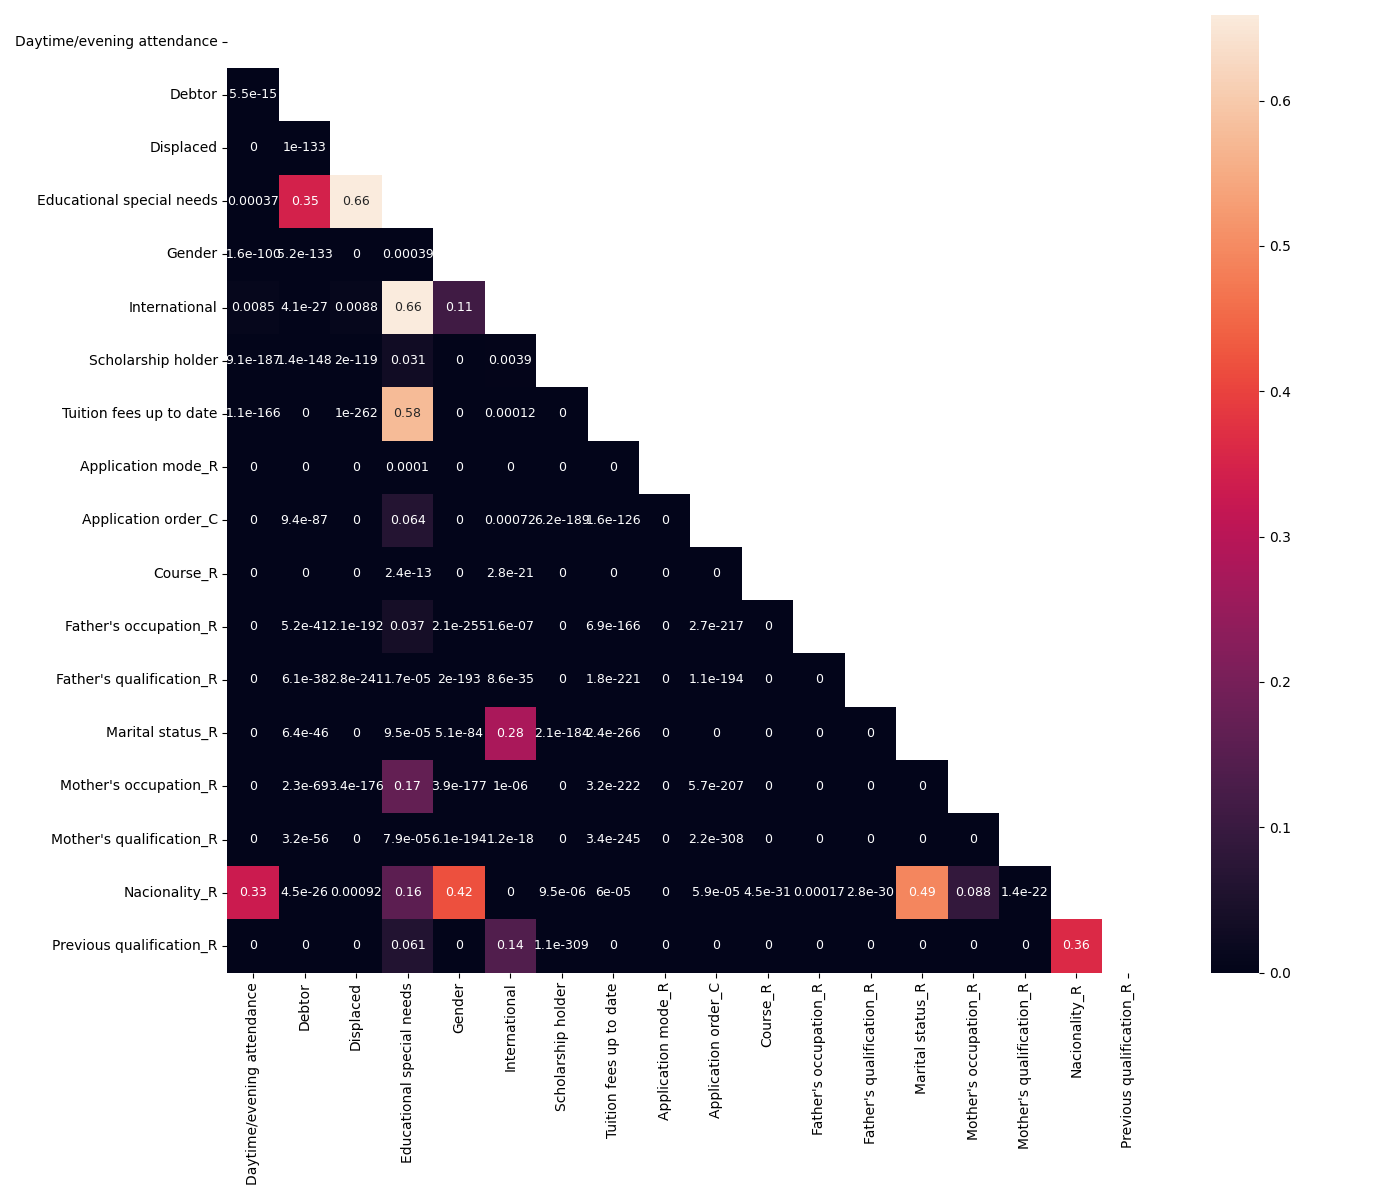

In [31]:
from scipy.spatial.distance import pdist, squareform
sc.cache_fig('heatmap_chi2_X_bool_X_cat_R',
    lambda x: sns.heatmap(
        pd.DataFrame(squareform(
                pdist(df_train[X_bool + X_cat_r].T, lambda u, v: chi2_contingency(pd.crosstab(u,v)).pvalue)
        ), index=X_bool + X_cat_r, columns=X_bool + X_cat_r), 
        annot=True, annot_kws={'fontsize':9}, mask=np.triu(np.ones((len(X_bool + X_cat_r), len(X_bool + X_cat_r)))), ax=x
    ), figsize=(14, 12)
)

# Continuous Variable

In [32]:
X_cont = ['Admission grade', 
'Age at enrollment', 
'Curricular units 1st sem (approved)',
'Curricular units 1st sem (credited)',
'Curricular units 1st sem (enrolled)',
'Curricular units 1st sem (evaluations)',
'Curricular units 1st sem (grade)',
'Curricular units 1st sem (without evaluations)',
'Curricular units 2nd sem (approved)',
'Curricular units 2nd sem (credited)',
'Curricular units 2nd sem (enrolled)',
'Curricular units 2nd sem (evaluations)',
'Curricular units 2nd sem (grade)',
'Curricular units 2nd sem (without evaluations)',
'GDP', 'Previous qualification (grade)', 'Unemployment rate']
len(X_cont)

17

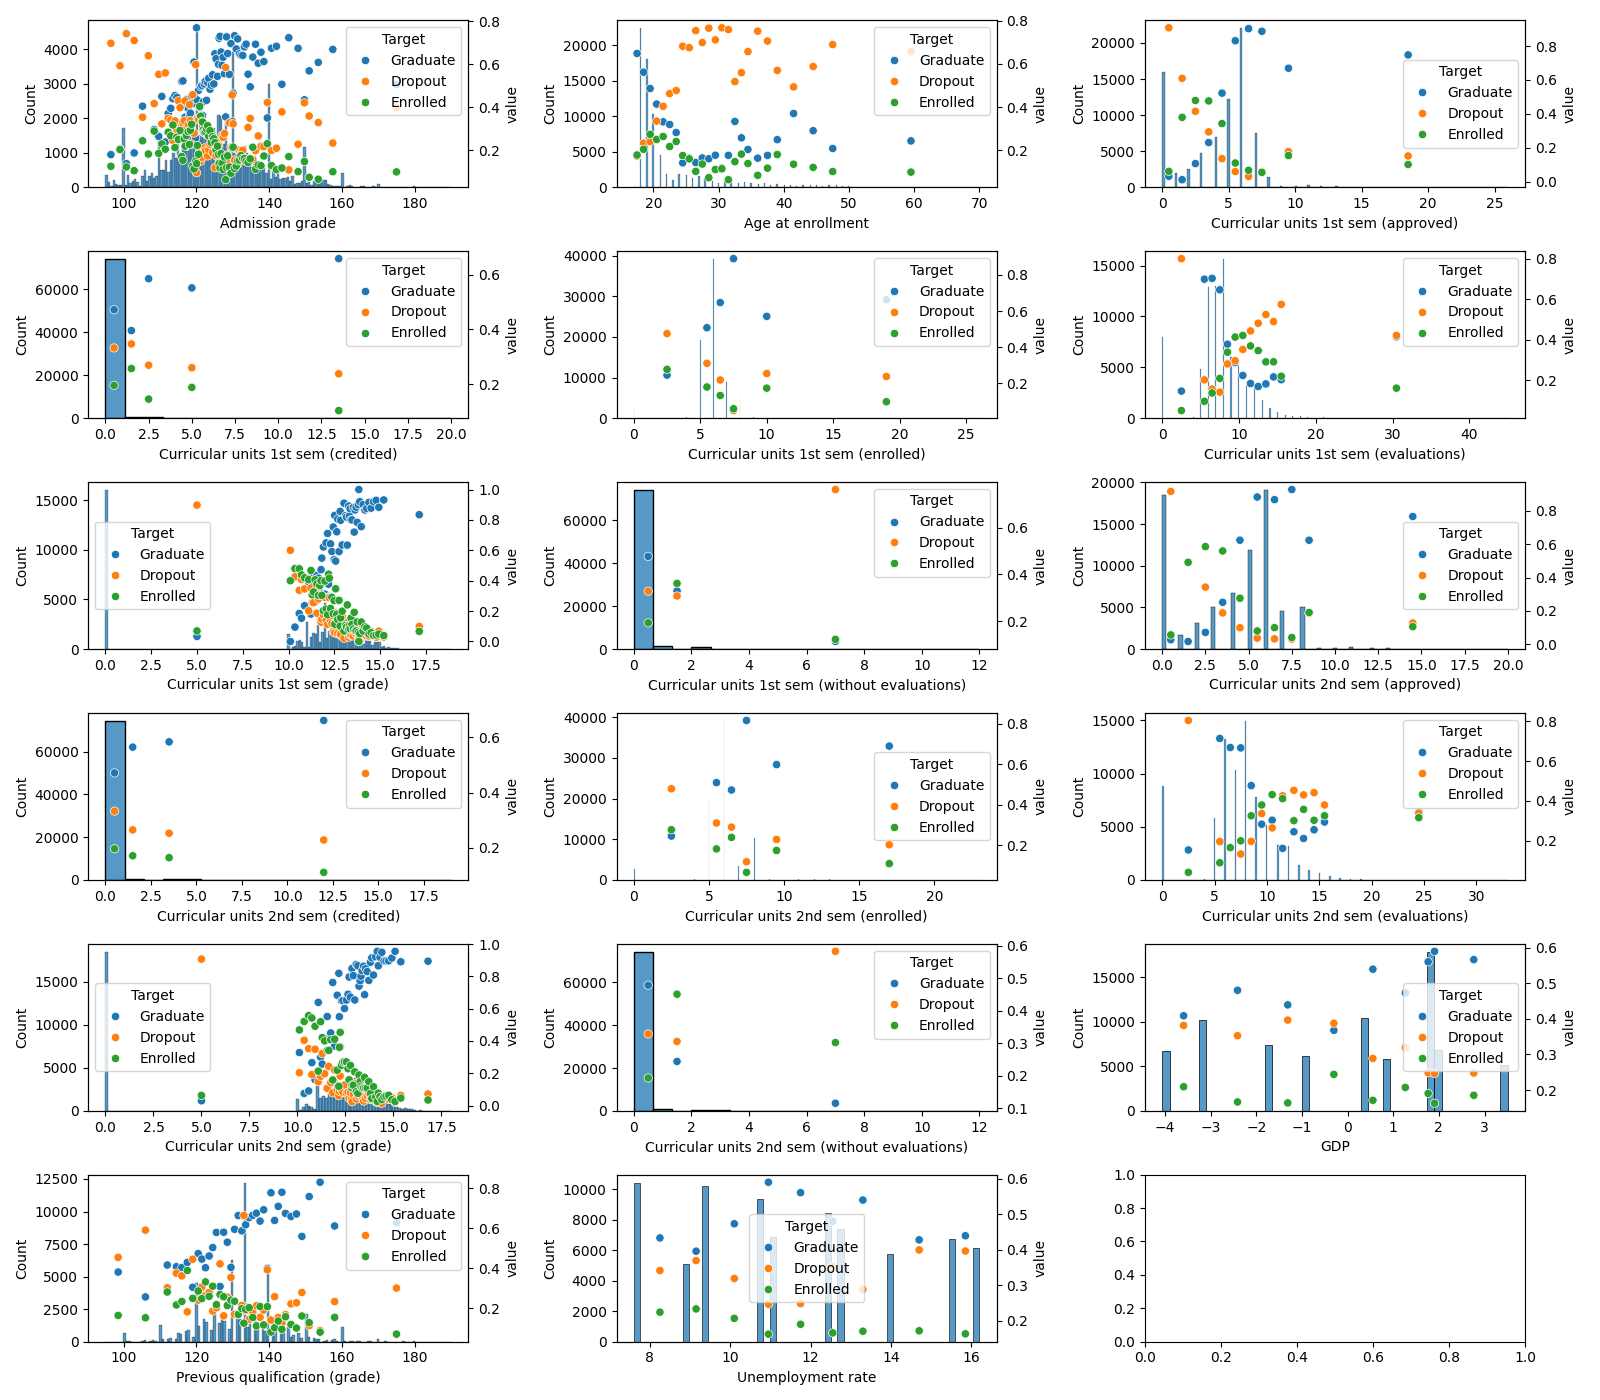

In [35]:
def plot_hist_scatter(v, ax):
    sns.histplot(df_train, x = v, ax=ax)
    pd.crosstab(
        index=pd.qcut(df_train[v], q=100, duplicates='drop'),
        columns=df_train[target], normalize='index'
    ).assign(
        **{v: lambda x: x.index.map(lambda x: (x.left + x.right) / 2)}
    ).pipe(lambda x: sns.scatterplot(x.melt(id_vars=v), x=v, y='value', hue='Target', ax=ax.twinx()))

sc.cache_fig('cont_hist_scatter',  lambda x: [plot_hist_scatter(v, ax) for v, ax in zip(X_cont, x)], 6, 3, figsize=(16, 14))

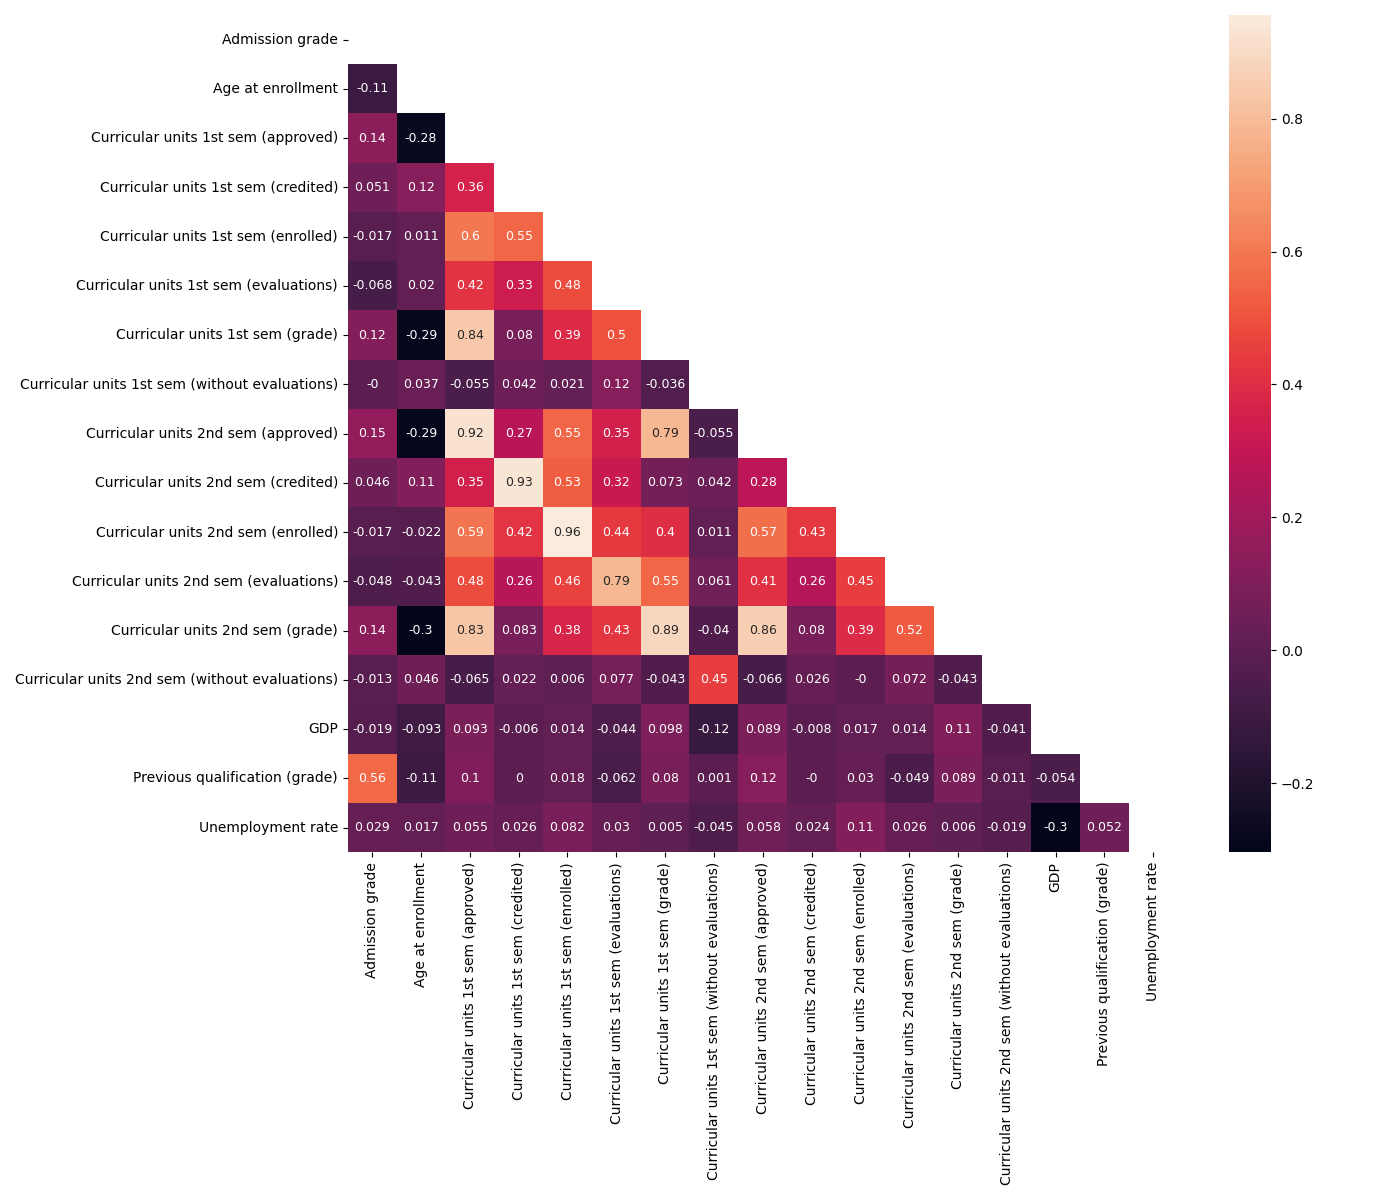

In [36]:
sc.cache_fig('heatmap_X_cont_corr',
    lambda x: sns.heatmap(
        df_train[X_cont].corr().map(lambda x: round(x, 3)),
        annot=True, annot_kws={'fontsize':9}, mask=np.triu(np.ones((len(X_cont), len(X_cont)))), ax=x
    ), figsize=(14, 12)
)

## Kruskal with target

In [37]:
from scipy.stats import kruskal
sc.cache_result('Kruskal',
    lambda : df_train.groupby(target, observed=True)[X_cont].agg(list).apply(
            lambda x: pd.Series(kruskal(*x), index=['statistic', 'pvalue'])
        ).T.sort_values('pvalue')
)

,statistic,pvalue
Admission grade,2813.604041,0.000000e+00
Curricular units 2nd sem (grade),39218.182492,0.000000e+00
Curricular units 2nd sem (evaluations),9388.457625,0.000000e+00
Curricular units 2nd sem (enrolled),9076.719109,0.000000e+00
Previous qualification (grade),2101.718067,0.000000e+00
Curricular units 1st sem (grade),34801.824128,0.000000e+00
Curricular units 2nd sem (approved),46716.267951,0.000000e+00
Curricular units 1st sem (enrolled),8763.334639,0.000000e+00
Curricular units 1st sem (approved),42030.077543,0.000000e+00
Age at enrollment,10807.626415,0.000000e+00


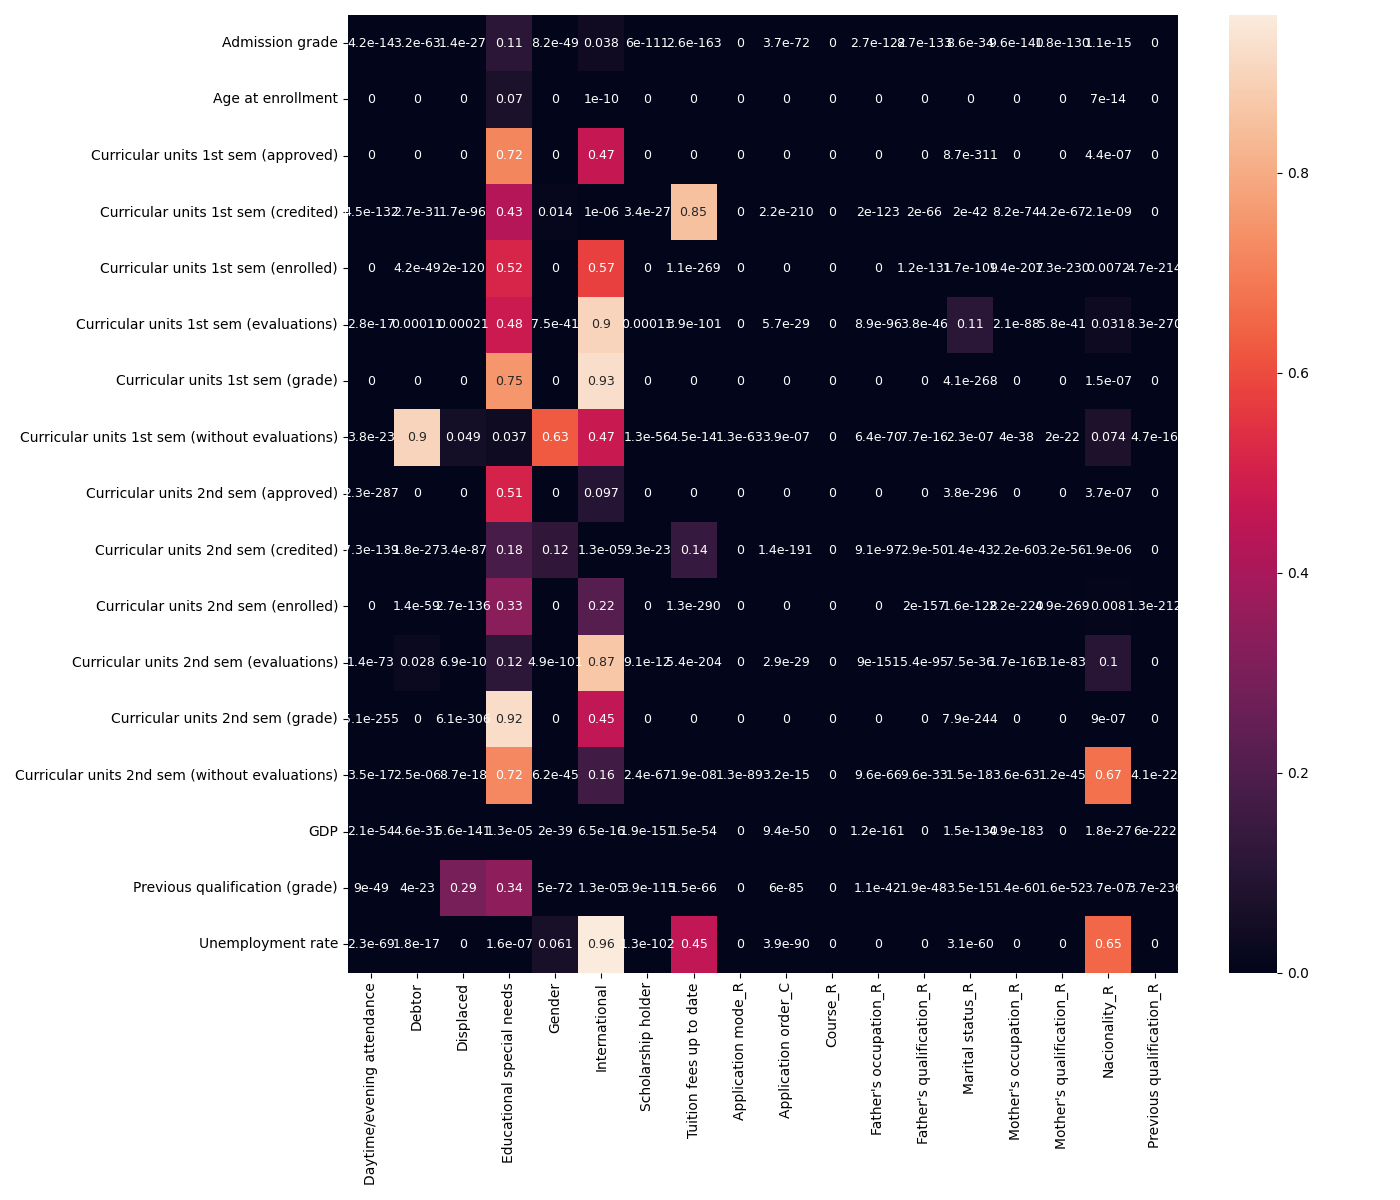

In [38]:
sc.cache_fig('heatmap_kruscal_X_bool_X_cat_R',
    lambda x: sns.heatmap(
        df_train[X_bool + X_cat_r].apply(
            lambda x: df_train.groupby(x, observed=True)[X_cont].agg(list).apply(lambda x: kruskal(*x).pvalue, axis=0)
        ), annot=True, annot_kws={'fontsize':9}, ax=x
    ), figsize=(14, 12)
)

# Feature Analysis with LightGBM

In [135]:
import importlib
import sgnn
importlib.reload(sgnn)

<module 'sgnn' from '/mnt/d/work/sunkusun9/kaggle/PGS4_ep6/sgnn.py'>

In [136]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sgml

ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)
target_values = np.sort(df_train[target].unique())

def get_validation_splitter(validation_frac):
    return lambda x: train_test_split(x, test_size=validation_frac, stratify=x[target], random_state=123)

config = {
    'predict_func': lambda m, df, X: pd.DataFrame(m.predict_proba(df[X]), index=df.index, columns=target_values),
    'score_func': lambda df, prd: accuracy_score(df[target], prd.idxmax(axis=1)),
    'validation_splitter': get_validation_splitter,
    'y': target
}

lgb_adapter = sgml.LGBMAdapter(lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(xgb.XGBClassifier, lambda _, x: x.map({k: v for v, k in enumerate(target_values)}))
cb_adapter = sgml.CBAdapter(cb.CatBoostClassifier)
nn_adapter = sgnn.NNAdapter(sgnn.NNClassifier)

In [116]:
result = sgml.cv(df_train, ss, {
    'model_params': {'n_estimators': 900, 'learning_rate': 0.01}, 
    'validation_fraction': 0.0,
    'X_num': X_cont, 'X_cat': X_bool + X_cat_r
}, config, lgb_adapter)

Round:   0%|          | 0/900 [00:00<?, ?it/s]

In [40]:
result = sgml.cv(df_train, ss, {
    'model_params': {'n_estimators': 900, 'learning_rate': 0.01}, 
    'validation_fraction': 0.1,
    'X_num': X_cont, 'X_cat': X_bool + X_cat_r
}, config, xgb_adapter)

Round:   0%|          | 0/900 [00:00<?, ?it/s]

In [41]:
result = sgml.cv(df_train, ss, {
    'model_params': {'n_estimators': 10, 'learning_rate': 0.01}, 
    'validation_fraction': 0.1,
    'X_num': X_cont, 'X_cat': X_bool + X_cat_r
}, config, cb_adapter)

Round:   0%|          | 0/10 [00:00<?, ?it/s]

In [137]:
sgml.cv(df_train, ss, {
    'model_params': {
        'model_params': {
            'config': [
                {'unit': 128, 'activation': 'relu', 'batch_norm': True},
                {'unit': 128, 'activation': 'relu', 'batch_norm': True},
                {'unit': 64, 'activation': 'relu', 'batch_norm': True},
                {'unit': 32, 'activation': 'relu', 'batch_norm': True},
            ], 'embedding': [(1, 3, 2, 0, 0)],
        },
        'batch_size': 256,
        'shuffle_size': 204800, 'epochs': 50, 'optimizer': ('Adam', {'learning_rate': 0.0001})
    }, 
    'validation_fraction': 0.1,
    'X_std': X_cont,
    'X_ohe': X_bool, 'ohe_drop': 'first',
    'X_cat': ['Marital status_R'],
}, config, nn_adapter)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Step:   0%|          | 0/216 [00:00<?, ?it/s]

{'valid_scores': [0.8129900679560899],
 'valid_prd':         Dropout  Enrolled  Graduate
 id                                 
 68562  0.004937  0.004691  0.990372
 6306   0.550189  0.402988  0.046823
 69013  0.011795  0.040256  0.947949
 8720   0.003216  0.008120  0.988664
 26364  0.018254  0.047033  0.934713
 ...         ...       ...       ...
 34753  0.856540  0.120552  0.022908
 45737  0.003336  0.028905  0.967759
 2783   0.175165  0.788726  0.036109
 8051   0.995323  0.003691  0.000986
 25742  0.072328  0.386658  0.541014
 
 [15304 rows x 3 columns],
 'model_result': [{'history':         loss  val_loss
   0   0.791295  0.589753
   1   0.560457  0.529386
   2   0.523751  0.509431
   3   0.506236  0.497373
   4   0.494180  0.489897
   5   0.487296  0.484300
   6   0.480209  0.480091
   7   0.476259  0.477740
   8   0.472789  0.476121
   9   0.468867  0.473741
   10  0.466172  0.473264
   11  0.463698  0.471363
   12  0.462013  0.471204
   13  0.458211  0.469806
   14  0.457243  0.46

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
clf_nn = Pipeline([
    ('ct', ColumnTransformer([
        ('std', StandardScaler(), X_cont),
        ('ord', OrdinalEncoder(), ['Marital status_R'])
    ])),
    ('nn', sgnn.NNClassifier(
        model_params={
            'config': [
                {'unit': 128, 'activation': 'relu', 'batch_norm': True},
                {'unit': 128, 'activation': 'relu', 'batch_norm': True},
                {'unit': 64, 'activation': 'relu', 'batch_norm': True},
                {'unit': 32, 'activation': 'relu', 'batch_norm': True},
            ],
            'embedding': [(1, 3, 2, 0, 0)]
        },
        optimizer=('Adam', {'learning_rate': 0.001}),
        batch_size=128,
        shuffle_size=204800,
        validation_splitter=lambda X, y: train_test_split(X, y, test_size=0.1, stratify=y),
        reduce_lr_on_plateau={'factor': 0.1, 'patience': 5},
        early_stopping={'patience': 10},
        epochs=150
    ))
])
clf_nn.fit(df_train[X_cont + ['Marital status_R']], df_train[target], nn__cb=[sgnn.FitProgressBar(metric='val_MSE', greater_is_better=False, postfix_step=30, prog_level=1)])

2024-11-16 10:16:49.488682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-16 10:16:49.597099: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Step:   0%|          | 0/539 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [77]:
df_train

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Marital status_R,Application mode_R,Application order_C,Course_R,Previous qualification_R,Nacionality_R,Mother's qualification_R,Father's qualification_R,Mother's occupation_R,Father's occupation_R
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.000000,1,1,19,...,single,1st phase - general contingent,1,Social Service,Secondary education,Portuguese;,Secondary Education - 12th Year of Schooling o...,Basic Education 3rd Cycle (9th/10th/11th Year)...,"Personal Services, Security and Safety Workers...","Personal Services, Security and Safety Workers..."
1,1,17,1,9238,1,1,125.000000,1,19,19,...,single,2nd phase - general contingent,1,Social Service,Secondary education,Portuguese;,Basic Education 3rd Cycle (9th/10th/11th Year)...,Basic Education 3rd Cycle (9th/10th/11th Year)...,Unskilled Workers,Unskilled Workers
2,1,17,2,9254,1,1,137.000000,1,3,19,...,single,2nd phase - general contingent,2,Tourism,Secondary education,Portuguese;,Higher Education - Degree,Basic Education 3rd Cycle (9th/10th/11th Year)...,Specialists in Intellectual and Scientific Act...,Intermediate Level Technicians and Professions
3,1,1,3,9500,1,1,131.000000,1,19,3,...,single,1st phase - general contingent,3,Nursing,Secondary education,Portuguese;,Basic Education 3rd Cycle (9th/10th/11th Year)...,Higher Education - Degree,Intermediate Level Technicians and Professions,Specialists in Intellectual and Scientific Act...
4,1,1,2,9500,1,1,132.000000,1,19,37,...,single,1st phase - general contingent,2,Nursing,Secondary education,Portuguese;,Basic Education 3rd Cycle (9th/10th/11th Year)...,Basic education 1st cycle (4th/5th year) or eq...,Administrative staff,Unskilled Workers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,1,17,1,9254,1,1,121.000000,1,19,1,...,single,2nd phase - general contingent,1,Tourism,Secondary education,Portuguese;,Basic Education 3rd Cycle (9th/10th/11th Year)...,Secondary Education - 12th Year of Schooling o...,"Skilled Workers in Industry, Construction and ...","Personal Services, Security and Safety Workers..."
76514,1,1,6,9254,1,1,125.000000,1,1,38,...,single,1st phase - general contingent,6,Tourism,Secondary education,Portuguese;,Secondary Education - 12th Year of Schooling o...,Basic Education 2nd Cycle (6th/7th/8th Year) o...,Administrative staff,Unskilled Workers
76515,5,17,1,9085,1,1,138.000000,1,37,37,...,married,2nd phase - general contingent,1,Veterinary Nursing,Secondary education,Portuguese;,Basic education 1st cycle (4th/5th year) or eq...,Basic education 1st cycle (4th/5th year) or eq...,Unskilled Workers,Armed Forces Professions
